In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score
from sklearn.model_selection import train_test_split

import cv2
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Input, Dense,Conv2D , MaxPooling2D, Flatten,BatchNormalization,Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
folder_path_no = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL"
folder_path_yes = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"

folder_no = os.listdir(folder_path_no)
folder_yes = os.listdir(folder_path_yes)

print(len(folder_no))
print(len(folder_yes))

1341
3875


In [4]:
from sklearn.utils import shuffle
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

path_no = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/"
path_yes = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/"

img_width, img_height = 224, 224


data_no = np.array([img_to_array(load_img(path_no + img, target_size=(img_width, img_height))) for img in os.listdir(path_no)])
data_yes = np.array([img_to_array(load_img(path_yes + img, target_size=(img_width, img_height))) for img in os.listdir(path_yes)])

labels_no = np.zeros(len(data_no))
labels_yes = np.ones(len(data_yes))

data = np.concatenate([data_no, data_yes])
labels = np.concatenate([labels_no, labels_yes])

data, labels = shuffle(data, labels, random_state=42)
data_train=data/255.0

In [5]:
folder_path_test_normal = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/"
folder_path_test_pneumonia = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/"

folder_test_no = os.listdir(folder_path_test_normal)
folder_test_yes = os.listdir(folder_path_test_pneumonia)

print(len(folder_test_no))
print(len(folder_test_yes))

234
390


In [6]:
test_no_label = [0]*len(folder_test_no)
test_yes_label = [1]*len(folder_test_yes)
test_labels = test_no_label + test_yes_label
print(len(test_labels))

624


In [7]:
path_no = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/"
path_yes = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/"

img_width, img_height = 224, 224

datagen = ImageDataGenerator(rescale=1./255)

data_no = np.array([img_to_array(load_img(path_no + img, target_size=(img_width, img_height))) for img in os.listdir(path_no)])
data_yes = np.array([img_to_array(load_img(path_yes + img, target_size=(img_width, img_height))) for img in os.listdir(path_yes)])

labels_no = np.zeros(len(data_no))
labels_yes = np.ones(len(data_yes))

data_test = np.concatenate([data_no, data_yes])
labels_test = np.concatenate([labels_no, labels_yes])

data_test_shuffled, labels_test_shuffled = shuffle(data_test, labels_test, random_state=42)

In [8]:
data_test_normalised=data_test_shuffled/255.0

In [9]:
data.shape

(5216, 224, 224, 3)

In [10]:
data_test_normalised.shape

(624, 224, 224, 3)

In [9]:
x_train, x_val, y_train, y_val = train_test_split(data_train, labels, test_size=0.2, random_state=42)
x_test = np.concatenate([x_val, data_test_normalised])
y_test = np.concatenate([y_val, labels_test_shuffled])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_7 (Flatten)         (None, 50176)             0         
                                                                 
 dense_15 (Dense)            (None, 128)               6422656   
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 1)                 129       
                                                                 
Total params: 13460289 (51.35 MB)
Trainable params: 6422785 (24.50 MB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________
Epoch 1/

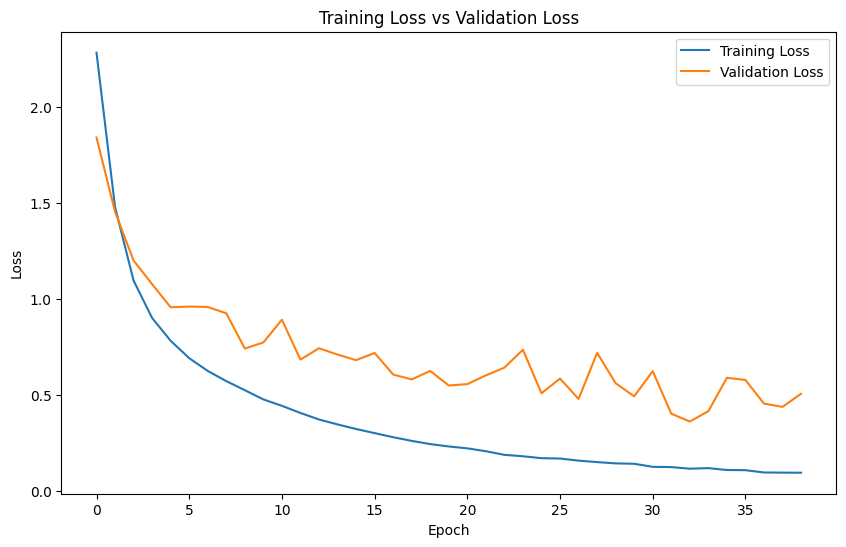

53/53 [==============================] - 5s 88ms/step - loss: 0.3618 - accuracy: 0.9305
Test Loss: 0.3618
Test Accuracy: 93.05%
53/53 [==============================] - 6s 86ms/step

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.85      0.88       519
         1.0       0.94      0.97      0.95      1149

    accuracy                           0.93      1668
   macro avg       0.93      0.91      0.92      1668
weighted avg       0.93      0.93      0.93      1668



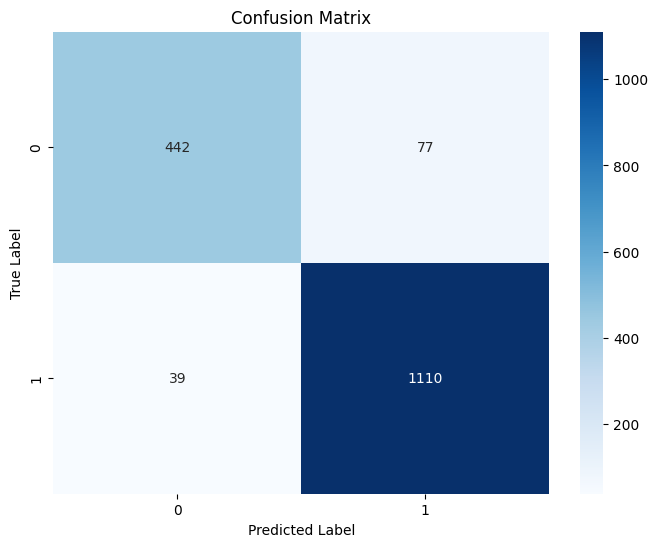

In [16]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

pre_trained_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in pre_trained_model.layers:
    layer.trainable = False

model = Sequential()

model.add(pre_trained_model)

model.add(Flatten())

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))


model.add(Dense(1, activation='sigmoid'))

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

model.compile(optimizer=Adam(learning_rate=0.00005), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_pred = model.predict(x_test)
y_pred_classes = np.round(y_pred)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
